# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Generating-dataset" data-toc-modified-id="Generating-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generating dataset</a></div><div class="lev1 toc-item"><a href="#Estimate-Parameters-of-NOE-and-NARX-models" data-toc-modified-id="Estimate-Parameters-of-NOE-and-NARX-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Estimate Parameters of NOE and NARX models</a></div><div class="lev1 toc-item"><a href="#Plot-Histogram" data-toc-modified-id="Plot-Histogram-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot Histogram</a></div>

In [26]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from oeshoot import narx
import multiprocessing
from joblib import Parallel, delayed
import matplotlib as mpl
num_cores = multiprocessing.cpu_count()
%matplotlib inline

# Generating dataset

The data set used for identification will be generated using the following equation:
\begin{equation}
y[n] = 0.5y[n-1]+0.8u[n-2]+u^2[n-1]-0.05y^2[n-2]+0.5
\end{equation}
The system input $u[n]$ is generated such that each value is hold for ten samples and have Gaussian distribution with zero  mean and unitary variance.

In [4]:
# Define System
def system_equation(y, u):
    ynext = 0.5*y[0]+0.8*u[1]+u[0]**2-0.05*y[1]**2+0.5
    return ynext
        
# System Parameters
N = 2
M = 2
Ny = 1
Nu = 1

In [5]:
# Defining parameters
rept = 2
random_samples = 200
total_time = rept*random_samples

# Time vector
n = np.arange(0, total_time)

# Generating input
u = np.random.normal(size=(random_samples,)).repeat(rept)

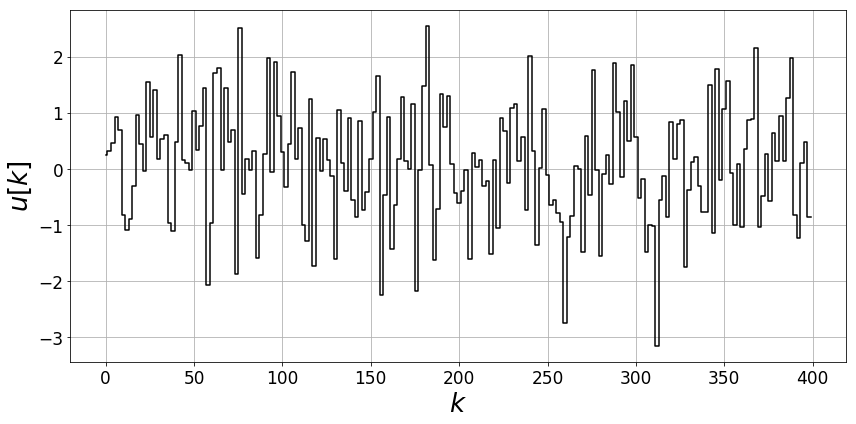

In [6]:
# Plot
label_size = 17
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
_, ax = plt.subplots(figsize=(12, 6))
ax.step(n, u, color='black')
ax.set_xlabel("$k$", fontsize=26)
ax.set_ylabel("$u[k]$", fontsize=26)
ax.grid()
plt.tight_layout()
plt.show()

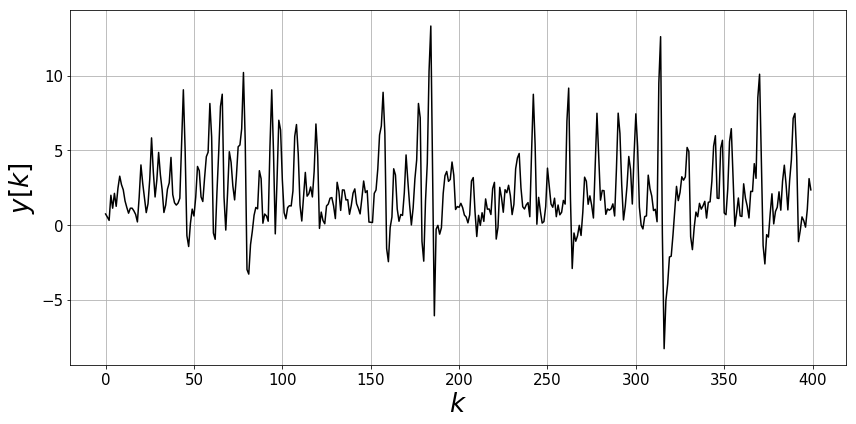

In [40]:
# Initialize input
y = np.empty_like(u)

# Initial Conditions
y0 = [0, 0]

# Simulate it
y[0:2] = y0
for i in range(2, len(y)):
    y[i] = system_equation([y[i-1], y[i-2]], [u[i-1], u[i-2]])+np.random.normal(scale=0.00001)


# Noise free data
ynoise_free = y

# Generate noise
v = np.random.normal(scale=0.5, size=y.shape)

# Data corrupted with noise
ynoisy = ynoise_free + v

# Divide between validation and training set
Ni = 600
Nv = len(y) - Ny

# Identification data
yi = ynoisy[:Ni].reshape([-1, 1])
ui = u[:Ni].reshape([-1, 1])

# Validation data
yv = ynoise_free[Ni:].reshape([-1, 1])
uv = u[Ni:].reshape([-1, 1])

# Plot
_, ax = plt.subplots(figsize=(12, 6))
ax.plot(n, ynoisy, label='Noisy data', color='black')
ax.set_xlabel("$k$", fontsize=26)
ax.set_ylabel("$y[k]$", fontsize=26)
ax.grid()
plt.tight_layout()
plt.show()

# Estimate Parameters of NOE and NARX models


In [41]:
# Polynomial model
m1 = narx.Monomial(1, 0, [1], [])
m2 = narx.Monomial(0, 1, [], [2])
m3 = narx.Monomial(0, 1, [], [1], [], [2])
m4 = narx.Monomial(1, 0, [2], [], [2], [])
m5 = narx.Monomial(0, 0, [], [], [], [])
mdl = narx.Polynomial([m1, m2, m3, m4, m5])

# Define error objects
sim_error = narx.SimulationError(mdl, ys, ui, maxlength=np.Inf)
predict_error = narx.PredictionError(mdl, yi, ui)

initial_guess = np.zeros_like(theta)

# Estimate params using prediction error
params_predict, info = predict_error.lsq_estimate_parameters(initial_guess)

# Estimate params using simulation error
params_sim, info = sim_error.lsq_estimate_parameters(initial_guess, use_sparse=True, use_jacobian=True)

# Show estimated parameter
params_sim

array([ 0.5 ,  0.8 ,  1.  , -0.05,  0.5 ])

# Plot Histogram

Repeat the same experiment multiple times

In [42]:
# Noise levels
noise_levels = np.linspace(0.01, 1.2, 10)

# Numer of trials
ntrials = 100


def evaluate_estimator(i, nn):
    np.random.seed(i+int(10*nn))
    # Generating output
    y = narx.simulate(mdl, y0, ui, theta)
    y = np.vstack((y0, y[:-1]))

    # Add noise
    y += np.random.normal(scale=nn, size=y.shape)

    # Define errors
    sim_error = narx.SimulationError(mdl, y, ui, maxlength=np.Inf)
    predict_error = narx.PredictionError(mdl, y, ui)

    # Estimate params using prediction error
    params_predict, info = predict_error.lsq_estimate_parameters(initial_guess)

    # Estimate params using simulation error
    params, info = sim_error.lsq_estimate_parameters(initial_guess, use_sparse=True)

    return [params, params_predict]

In [43]:
# Only do the computation when necessary
if os.path.isfile('polynomial_results_ms.npy'):
    results=np.load('polynomial_results_ms.npy')
else:
    results = Parallel(n_jobs=num_cores)(delayed(evaluate_estimator)(i, nn) for nn in noise_levels for i in range(ntrials))
    results = np.array(results)
    results = results.reshape((len(noise_levels), ntrials, 2, len(theta)))
    np.save('polynomial_results_ms.npy', results)

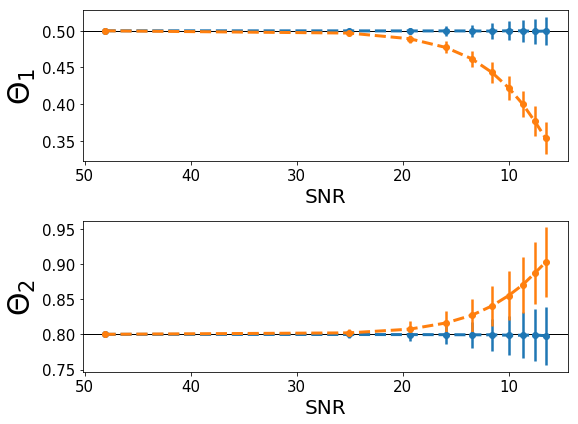

In [44]:
# Compute mean and standard deviation
mean = np.mean(results, axis=1)
std = np.std(results, axis=1)

label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig, ax = plt.subplots(2, 1,figsize= (8, 3*2))

for pn in range(2):
    (_, caps, _) = ax[pn].errorbar(10*np.log10(np.var(ynoise_free)/noise_levels**2), mean[:, 0, pn], yerr=std[:, 0, pn], fmt='--o', ms=6, elinewidth=2.5, linewidth=3)
    for cap in caps:
        cap.set_markeredgewidth(2.5)
    (_, caps, _) = ax[pn].errorbar(10*np.log10(np.var(ynoise_free)/noise_levels**2), mean[:, 1, pn], yerr=std[:, 1, pn], fmt='--o', ms=6, elinewidth=2.5, linewidth=3)
    for cap in caps:
        cap.set_markeredgewidth(2.5)
    ax[pn].axhline(theta[pn], color='black', linestyle='-', lw=1)
    ax[pn].set_ylabel(r'$\Theta_'+str(pn+1)+'$', fontsize=30)
    ax[pn].set_xlabel('SNR', fontsize=20)
    ax[pn].set_xlim(ax[pn].get_xlim()[::-1])
    if pn==3:
        ax[pn].set_yticks([-0.05, -0.04, -0.03, -0.02])

plt.tight_layout()
plt.savefig("single_shooting1.pdf")
plt.show()